# MDPs in TensorFlow - 1-step Navigation

In this notebook, we will consider the problem of 1-step Navigation from a start position to an end position. The goal is to find the optimal policy that recommends the action that best aligns the agent in the direction of the goal position.

We shall define a policy by a single real-valued parameter that specifies the angular orientation of a unit vector representing a displacement in the grid.

## Imports

In [1]:
import collections
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib notebook

## Navigation MDP model 

In [2]:
class Navigation():

    def __init__(self, graph, config):
        self.graph = graph

        self.config = config
        self.ndim = config["grid"]["ndim"]

        with self.graph.as_default():
            with tf.name_scope("constants/grid"):
                self._goal = tf.constant(config["grid"]["goal"], dtype=tf.float32, name="goal")
                
            with tf.name_scope("constants/next_position"):
                self._scale = tf.constant(config["grid"]["scale"])

    @property
    def action_size(self):
        return self.ndim

    @property
    def state_size(self):
        return self.ndim

    def transition(self, state, action):
        with self.graph.as_default():
            with tf.name_scope("transition/next_position"):
                p = tf.add(state, action, name="p")
                next_state_dist = tf.distributions.Normal(loc=p, scale=self._scale, name="next_state_dist")
        return next_state_dist

    def reward(self, state):
        with self.graph.as_default():
            with tf.name_scope("reward"):
                r = -tf.sqrt(tf.reduce_sum(tf.square(state - self._goal), axis=1, keepdims=True), name="r")
        return r


## Policy

In [3]:
def policy(graph):
    with graph.as_default():
        with tf.variable_scope("policy"):
            theta = tf.get_variable("theta", dtype=tf.float32, initializer=tf.constant(np.pi))
            action = tf.reshape([tf.cos(theta), tf.sin(theta)], shape=(2,), name="action")
    def wrapper(state):
        return tf.ones_like(state) * action
    return wrapper, theta


## Markov Recurrent Model

In [4]:
class MarkovCell(tf.nn.rnn_cell.RNNCell):

    def __init__(self, mdp, policy):
        self.mdp = mdp
        self.policy = policy

    @property
    def input_size(self):
        return 1

    @property
    def state_size(self):
        return self.mdp.state_size

    @property
    def output_size(self):
        return 2 * self.mdp.state_size + self.mdp.action_size + 2

    def __call__(self, inputs, state, scope=None):

        with self.mdp.graph.as_default():

            with tf.name_scope("policy_cell"):
                timestep = inputs
                action = self.policy(state)

            with tf.name_scope("transition_cell"):
                next_state_dist = self.mdp.transition(state, action)
                next_state = next_state_dist.sample(name="next_state")

            with tf.name_scope("reward_cell"):
                reward = self.mdp.reward(next_state)

            with tf.name_scope("output"):
                outputs = tf.concat([timestep, state, action, reward, next_state], axis=1)

        return outputs, next_state


class MarkovRecurrentModel(object):
    
    Trajectory = collections.namedtuple("Trajectory", "timesteps states actions rewards next_states")

    def __init__(self, mdp, policy):
        self.mdp = mdp
        self.policy = policy
        self._cell = MarkovCell(mdp, policy)

    def unroll(self, initial_state, inputs):

        max_time = inputs.shape[1]

        input_size = self._cell.input_size
        state_size = self._cell.mdp.state_size
        action_size = self._cell.mdp.action_size

        with self.mdp.graph.as_default():

            self.initial_state = tf.constant(initial_state, name="initial_state")
            self.inputs = tf.constant(inputs, name="inputs")

            outputs, final_state = tf.nn.dynamic_rnn(
                                    self._cell,
                                    self.inputs,
                                    initial_state=self.initial_state,
                                    dtype=tf.float32,
                                    scope="recurrent")

            with tf.name_scope("recurrent/trajectory"):
                timestep_idx = 0
                state_idx = timestep_idx + 1
                action_idx = state_idx + state_size
                reward_idx = action_idx + action_size
                next_state_idx = reward_idx + 1

                outputs = tf.unstack(outputs, axis=2)

                timesteps = tf.reshape(outputs[timestep_idx], [-1, max_time, 1], name="timesteps")
                states = tf.stack(outputs[state_idx : action_idx], axis=2, name="states")
                actions = tf.stack(outputs[action_idx: reward_idx], axis=2, name="actions")
                rewards = tf.reshape(outputs[reward_idx], [-1, max_time, 1], name="rewards")
                next_states = tf.stack(outputs[next_state_idx : ], axis=2, name="next_states")

        return MarkovRecurrentModel.Trajectory(timesteps=timesteps, states=states, actions=actions, rewards=rewards, next_states=next_states)


In [5]:
def initial_state(state, batch_size):
    return np.repeat([state], batch_size, axis=0).astype(np.float32)

def timesteps(batch_size, max_time):
    timesteps = [np.arange(start=max_time-1, stop=-1.0, step=-1.0, dtype=np.float32)]
    timesteps = np.repeat(timesteps, batch_size, axis=0)
    timesteps = np.reshape(timesteps, (batch_size, max_time, 1))
    return timesteps


## Simulation

In [6]:
# hyperparameters
batch_size = 100000
max_time = 1

# computation graph
graph = tf.Graph()

# MDP
config = {
    "initial": [2.0, 5.0],
    "grid": {
        "ndim": 2,
        "size":  [[0.0, 0.0], [10.0, 10.0]],
        "goal":  [8.0,  5.0],
        "scale": [0.1, 0.1]
    }
}
mdp = Navigation(graph, config)

# Policy
pi, theta = policy(graph)

# Markov Recurrent Model
start = config["initial"]
mrm = MarkovRecurrentModel(mdp, pi)
trajectory = mrm.unroll(initial_state(start, batch_size), timesteps(batch_size, max_time))


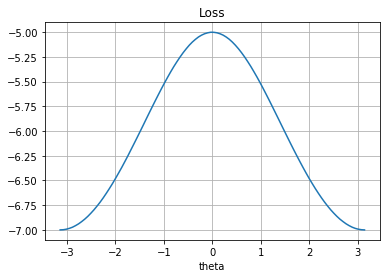

In [7]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    loss = tf.reduce_mean(trajectory.rewards, axis=0, name="loss")
    
    thetas = np.linspace(-np.pi, np.pi, 100)
    losses = []
    for theta_ in thetas:
        feed_dict = { theta: theta_ }
        loss_, = sess.run([loss], feed_dict=feed_dict)
        losses.append(loss_.flatten()[0])

plt.plot(thetas, losses)
plt.title("Loss")
plt.xlabel("theta")
plt.grid()
plt.show()


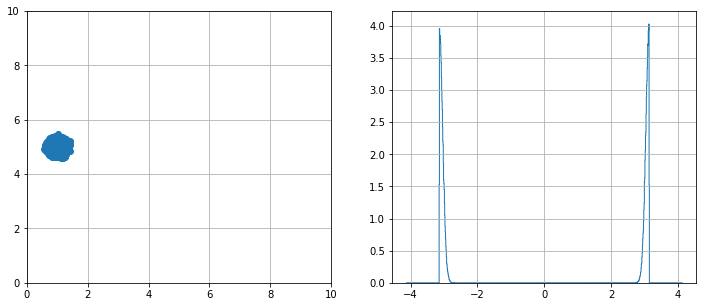

In [8]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    states, next_states = sess.run([trajectory.states, trajectory.next_states])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# next position
x = next_states[:, 0, 0]
y = next_states[:, 0, 1]
ax1.scatter(x, y)
ax1.set_xlim(0.0, 10.0)
ax1.set_ylim(0.0, 10.0)
ax1.grid()

# next state distribution
displacements = next_states - states
x1, x2 = displacements[:, 0, 1], displacements[:, 0, 0]
theta_ = np.arctan2(x1, x2)
ax2.hist(theta_, bins=np.linspace(-np.pi - 1.0, np.pi + 1.0, 1000), histtype=u'step', normed=True)
ax2.grid()

plt.show()

## Optimization via Policy-Gradient

In [9]:
class PolicyGradientCell(tf.nn.rnn_cell.RNNCell):

    def __init__(self, mdp, policy):
        self.mdp = mdp
        self.policy = policy

    @property
    def input_size(self):
        return 2 * self.mdp.state_size + 2

    @property
    def state_size(self):
        return 1

    @property
    def output_size(self):
        return self.mdp.state_size + 2

    def __call__(self, inputs, h, scope=None):

        timestep_idx = 0
        state_idx = timestep_idx + 1
        next_state_idx = state_idx + self.mdp.state_size
        Q_idx = next_state_idx + self.mdp.state_size

        with self.mdp.graph.as_default():

            with tf.name_scope("pg_celll/inputs"):
                inputs = tf.unstack(inputs, axis=1, name="inputs")
                timestep = tf.reshape(inputs[timestep_idx], [-1, 1], name="timestep")
                state = tf.stack(inputs[state_idx : next_state_idx], axis=1, name="state")
                next_state = tf.stack(inputs[next_state_idx : Q_idx], axis=1, name="next_state")
                Q = tf.reshape(inputs[Q_idx : ], [-1, 1], name="Q")

            with tf.name_scope("pg_cell/policy_cell"):
                action = self.policy(state)

            with tf.name_scope("pg_cell/transition_cell"):
                next_state_dist = self.mdp.transition(state, action)
                log_prob = next_state_dist.log_prob(next_state, name="log_prob")

            with tf.name_scope("pg_cell/reward_cell"):
                reward = self.mdp.reward(next_state)

            with tf.name_scope("pg_cell/outputs"):
                outputs = tf.concat([reward, log_prob, Q], axis=1, name="outputs")

            with tf.name_scope("pg_cell/next_h"):
                state_log_prob = tf.reduce_sum(log_prob, axis=1, keepdims=True, name="state_log_prob")
                weighted_log_prob = tf.multiply(Q, state_log_prob, name="weighted_log_prob")
                next_h = tf.add(h, weighted_log_prob, name="next_h")

        return outputs, next_h


class PolicyGradientOptimizer(object):

    def __init__(self, mdp, policy, trajectory, learning_rate):
        self.mdp = mdp
        self.policy = policy

        self.trajectory = trajectory
        self.batch_size = self.trajectory.states.shape[0].value
        self.max_time = self.trajectory.states.shape[1].value

        self.learning_rate = learning_rate

        with self.mdp.graph.as_default():
            with tf.name_scope("pg_optimizer"):
                self._total_reward()
                self._reward_to_go()
                self._loss()
                self._surrogate_loss()
                self._train_op()

    def _total_reward(self):
        self.total_reward = tf.reduce_sum(self.trajectory.rewards, axis=1, keepdims=True, name="total_reward")

    def _reward_to_go(self):
        self.Q = -tf.cumsum(self.total_reward, axis=1, reverse=True, name="Q")

    def _loss(self):
        self.loss = tf.reduce_mean(self.total_reward, axis=0, name="loss")

    def _surrogate_loss(self):
        self._cell = PolicyGradientCell(self.mdp, self.policy)

        self._initial_state = tf.zeros([self.batch_size, 1], name="initial_state")

        timesteps_shape = [self.batch_size, self.max_time, 1]
        states_shape = [self.batch_size, self.max_time, self.mdp.state_size]
        Q_shape = [self.batch_size, self.max_time, 1]

        self._timesteps = tf.placeholder(tf.float32, shape=timesteps_shape, name="timesteps")
        self._states = tf.placeholder(tf.float32, shape=states_shape, name="states")
        self._next_states = tf.placeholder(tf.float32, shape=states_shape, name="next_states")
        self._Q = tf.placeholder(tf.float32, shape=Q_shape, name="Q")
        self._inputs = tf.concat([self._timesteps, self._states, self._next_states, self._Q], axis=2, name="inputs")

        outputs, final_h = tf.nn.dynamic_rnn(
                                self._cell,
                                self._inputs,
                                initial_state=self._initial_state,
                                dtype=tf.float32,
                                scope="recurrent")

        self.surrogate_loss = tf.reduce_mean(final_h, name="surrogate_loss")

    def _train_op(self):
        self.optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
        self.grads_and_vars = self.optimizer.compute_gradients(self.surrogate_loss)
        self.train_op = self.optimizer.apply_gradients(self.grads_and_vars)

    def minimize(self, epochs, show_progress=True):
        losses = []
        grads = []
        parameters = []
        
        trajectory= []

        start = time.time()
        with tf.Session(graph=self.mdp.graph) as sess:
            sess.run(tf.global_variables_initializer())

            print(">> Optimizing policy ...")
            for step in range(epochs):

                # Sample trajectories
                timesteps, states, next_states, Q = sess.run([
                                                        self.trajectory.timesteps,
                                                        self.trajectory.states,
                                                        self.trajectory.next_states,
                                                        self.Q])
                trajectory.append((states, next_states))

                # Apply gradients and evaluate loss
                feed_dict = {
                    self._timesteps: timesteps,
                    self._states: states,
                    self._next_states: next_states,
                    self._Q: Q
                }
                loss, grads_and_vars, _ = sess.run([self.loss, self.grads_and_vars, self.train_op], feed_dict=feed_dict)
                
                loss = loss.flatten()
                losses.append(loss[0])
                
                grad, var = grads_and_vars[0]
                grads.append(grad)
                parameters.append(var)

                # Show progress
                if show_progress and step % 10 == 0:
                    print('Epoch {0:5}: loss = {1:.6f}\r'.format(step, loss[0]), end="")

        end = time.time()
        uptime = end - start
        print("\nDone in {0:.6f} sec.\n".format(uptime))

        return {
            "losses": losses,
            "grads": grads,
            "parameters": parameters,
            "trajectory": trajectory,
            "uptime": uptime
        }


In [10]:
learning_rate = 0.01
epochs = 1000

optimizer = PolicyGradientOptimizer(mdp, pi, trajectory, learning_rate)

results = optimizer.minimize(epochs)
losses = results["losses"]
grads = results["grads"]
parameters = results["parameters"]

>> Optimizing policy ...
Epoch   990: loss = -5.001133
Done in 94.351517 sec.



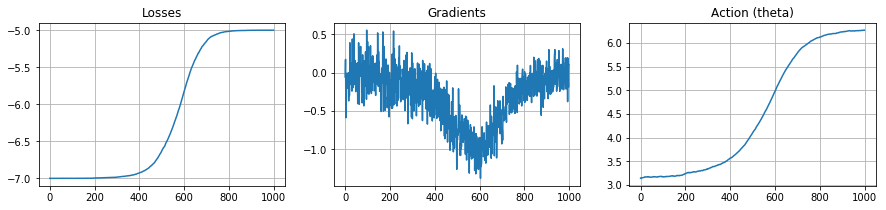

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

ax1.set_title("Losses")
ax1.plot(losses)
ax1.grid()

ax2.set_title("Gradients")
ax2.plot(grads)
ax2.grid()

ax3.set_title("Action (theta)")
ax3.plot(parameters)
ax3.grid()

plt.show()

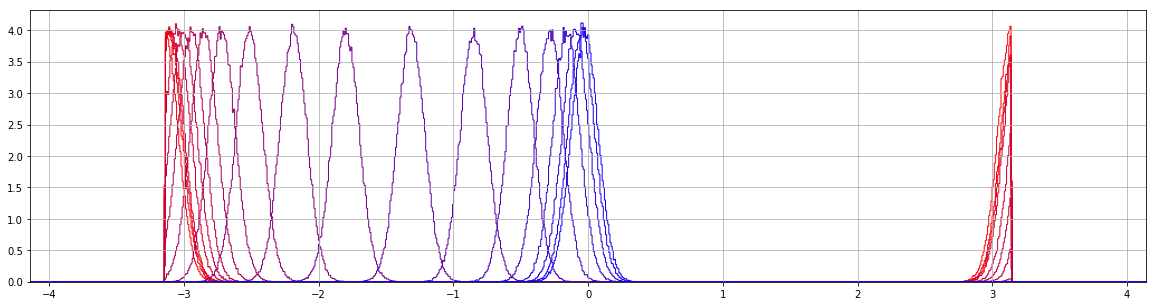

In [12]:
fig, ax = plt.subplots(figsize=(20, 5))

trajectory = results["trajectory"]
for i, (states, next_states) in enumerate(trajectory):
    if i % 50 == 0:
        displacements = next_states - states
        x1, x2 = displacements[:, 0, 1], displacements[:, 0, 0]
        theta_ = np.arctan2(x1, x2)
        ax.hist(theta_, bins=np.linspace(-np.pi - 1.0, np.pi + 1.0, 1000), histtype=u'step', normed=True, color=((len(trajectory) - i) / len(trajectory), 0, i / len(trajectory)))

ax.grid()
ax.set_xlim(- 1.0 - np.pi, np.pi + 1.0)
plt.show()

## Re-parameterization Trick

### Loss
$$
V^{\pi_{\theta}}(\mathbf{s}_0) = \mathbb{E}_{\mathbf{s}_1}[r_1(\mathbf{s}_1)]
$$

### Policy gradient (no reparameterization)
$$
\begin{align}
\mathbf{s}_1 &\sim p(\cdot~|~\mathbf{s}_0, \mathbf{a}) = \mathcal{N}(\mu, \sigma) \\
\mu &= \mathbf{s}_0 + \mathbf{a}\\
\sigma &= 0.1 \\
\mathbf{a} &= \pi_{\theta}(\mathbf{s}_0) \\
r_1 &= - || \mathbf{s}_1 - \mathbf{g} ||
\end{align}
$$

$$
\begin{align}
\nabla_{\theta} V^{\pi_{\theta}}(\mathbf{s}_0) &= \mathbb{E}_{\mathbf{s}_1} [\nabla_{\theta} \log p(\mathbf{s}_1|\mathbf{s}_0, \pi_{\theta})~r_1(\mathbf{s}_1)]\\
&= \nabla_{\theta} \pi_{\theta}(\mathbf{s}_0) \cdot \mathbb{E}_{\mathbf{s}_1} \left [\frac{\mathbf{s}_1 - \mu}{\sigma^2} r_1(\mathbf{s}_1) \right]
\end{align}
$$

### Policy gradient (reparameterization)
$$
\begin{align}
\mathbf{s}_1 &= \mu + \sigma \xi  \\
\mu &= \mathbf{s}_0 + \mathbf{a}\\
\sigma &= 0.1 \\
\xi &\sim \mathcal{N}(0, 1) \\
\mathbf{a} &= \pi_{\theta}(\mathbf{s}_0) \\
r_1 &= - || \mathbf{s}_1 - \mathbf{g} ||
\end{align}
$$

$$
\begin{align}
\nabla_{\theta} V^{\pi_{\theta}}(\mathbf{s}_0) &= \mathbb{E}_{\xi} [\nabla_{\theta} r_1(\mathbf{s}_1)]\\
&= \nabla_{\theta} \pi_{\theta}(\mathbf{s}_0) \cdot \mathbb{E}_{\xi} \left [ \frac{\mu + \sigma\xi - \mathbf{g}}{r_1(\mu + \sigma\xi)}  \right ]
\end{align}
$$

In [13]:
s0 = np.reshape([2.0, 5.0], (2, 1))
g = np.reshape([8.0, 5.0], (2, 1))

sigma = 0.1

def pi(theta):
    return np.reshape([np.cos(theta), np.sin(theta)], (2, 1))

def grad_pi(theta):
    return np.reshape([-np.sin(theta), np.cos(theta)], (1, 2))

def next_state(s0, a, sigma, noise):
    return (s0 + a) + sigma * noise

def sample_next_state(s0, a, batch_size):
    mu = s0 + a
    return np.random.normal(loc=mu, scale=sigma, size=(batch_size, 2, 1))

thetas = np.linspace(-np.pi, np.pi, 1000)
grads1, grads2 = [], []

for theta in thetas:
    a = pi(theta)
    grad_a = grad_pi(theta)

    # re-parameterization
    batch_size = 10
    noise = np.random.normal(size=(batch_size, 2, 1))
    s1 = next_state(s0, a, sigma, noise)
    r1 = - np.linalg.norm(s1 - g, axis=1, keepdims=True)
    grad1 = np.mean((s1 - g) / r1, axis=0, keepdims=False)
    grads1.append(np.dot(grad_a, grad1).flatten())

    # policy gradient
    batch_size = 100000
    s1 = sample_next_state(s0, a, batch_size)
    r1 = - np.linalg.norm(s1 - g, axis=1, keepdims=True)
    grad2 = np.mean((s1 - (s0 + a)) / (sigma ** 2) * r1, axis=0, keepdims=False)
    grads2.append(np.dot(grad_a, grad2).flatten())


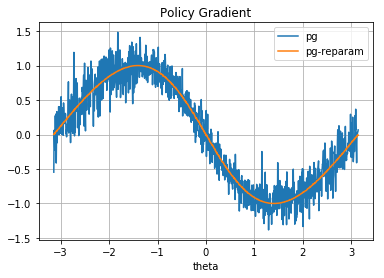

In [14]:
plt.title("Policy Gradient")
plt.xlabel("theta")
plt.plot(thetas, grads2, label="pg")
plt.plot(thetas, grads1, label="pg-reparam")
plt.legend()
plt.grid()
plt.show()